In [1]:
#This notebook calculates silhouette averages and clusters for Card Count and NGram playtraces for Dominion produced by the
#TableTop Games framework

In [2]:
!pip install scikit-learn-extra

In [3]:
import pandas as pd
import pdb
import re
import nltk
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from itertools import product, permutations, combinations
from nltk import ngrams
from nltk.probability import FreqDist
nltk.download('punkt')
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import jensenshannon
from google.colab import drive
import csv
import os
import warnings

drive.mount('/content/gdrive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#list of clustering methods to use
clustering_methods = ['KMeans', 'KMedoids', 'DBSCAN', 'SPCluster_KNN','SPCluster_RBF','SPCluster_DM']

#filenames and directory locations
google_drive_parent_dir = "gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/"
card_count_data_dir = google_drive_parent_dir + "DataCardCount/"
ngram_data_dir = google_drive_parent_dir + "DataNGrams/"
card_count_data_filename = card_count_data_dir + "trace_logfile_Budget50_vs_Budget500_GPM100_FG1E.txt"
ngram_data_filename = ngram_data_dir + "ActionsReduced_Budget50_vs_Budget500_GPM100_FG1E.csv"
tag_for_dir_and_filenames = 'MCTS_b50_vs_b500_GPM100_FG1E'
#card_count_data_filename = card_count_data_dir + "trace_logfile_Budget_500_vs_Budget_500_GPM100_SD_NoSelfPlay.txt"
#ngram_data_filename = ngram_data_dir + "ActionsReduced_Budget500_vs_Budget500_GPM100_SD.csv"
#tag_for_dir_and_filenames = 'MCTS_b500_vs_b500_GPM100_SD'

#create new directory for output files
for method in clustering_methods:
  new_dir_path = google_drive_parent_dir + 'Results_' + method + '/' + tag_for_dir_and_filenames + '/'
  os.makedirs(new_dir_path, exist_ok=True)

  # Verify that the directory has been created
  if os.path.exists(new_dir_path):
      print(f"Directory '{new_dir_path}' created successfully.")
  else:
      print(f"Failed to create directory '{new_dir_path}'.")

Directory 'gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/Results_KMeans/MCTS_b50_vs_b500_GPM100_FG1E/' created successfully.
Directory 'gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/Results_KMedoids/MCTS_b50_vs_b500_GPM100_FG1E/' created successfully.
Directory 'gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/Results_DBSCAN/MCTS_b50_vs_b500_GPM100_FG1E/' created successfully.
Directory 'gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/Results_SPCluster_KNN/MCTS_b50_vs_b500_GPM100_FG1E/' created successfully.
Directory 'gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/Results_SPCluster_RBF/MCTS_b50_vs_b500_GPM100_FG1E/' created successfully.
Directory 'gdrive/My Drive/Colab Notebooks/DominionPlayTraceClustering/Results_SPCluster_DM/MCTS_b50_vs_b500_GPM100_FG1E/' created successfully.


In [5]:
#parameters for notebook execution

#parameters if using TAG input data
logs_from_tag = True
agent_names = ['MediumA', 'MediumB']
games_per_matchup = 100
no_self_play = True

#parameters for grid search for clustering methods

#number of clusters to check across all clustering methods (excluding DBSCAN)
clusters_min = 2
clusters_max = 5
clusters_stepsize = 1

#DBSCAN
minpts_min = 5
minpts_max = 50
minpts_stepsize = 5
epsilon_min = 0.1
epsilon_max = 1
epsilon_stepsize = 0.1

#Spectral clustering K-Nearest Neighbours
nearest_neighbours_min = 5
nearest_neighbours_max = 50
nearest_neighbours_stepsize = 5

#Spectral clustering radial basis function
gamma_min = 0.1
gamma_max = 1
gamma_stepsize = 0.1

#number of N-gram types to search over
ngram_min = 1
ngram_max = 2
ngram_stepsize = 1

#kingdom card set
kingdom_set = 'FG1E'

In [6]:
#kingdom card types
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP','CURSE','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']

if kingdom_set == 'SD':
  card_types = card_types_SD
elif kingdom_set == 'FG1E':
  card_types = card_types_FG1E
else:
  print('Unrecognised kingdom card set')

In [7]:
#functions to process data from TAG

def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
    game_group = int((game_id - min_game_id)/no_games_per_matchup)
    matchup = matchup_list[game_group]
    agent1, agent2 = matchup
    if player_no == 0:
        return agent1
    else:
        return agent2

def add_TAG_agent_names(agent_names, games_per_match_up, no_self_play, logs_from_tag, data):
  NoOfGames = len(data['GameID'].unique())
  min_GameID = data['GameID'].min()

  #first generate match-ups
  matchups = []
  if no_self_play:
    matchups = list(permutations(agent_names, 2))
  else:
      for agent1 in agent_names:
          for agent2 in agent_names:
              matchups.append((agent1, agent2))

  #add agent names to data set
  data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)

  #finally we also add the name of the agent of the opponent
  min_GameID = data['GameID'].min()
  data['Opponent'] = data.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
  if logs_from_tag:
      data['AgentNameOpponent'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)
  else:
      gameid_to_players_dict = data.groupby('GameID')['AgentName'].apply(list).to_dict()
      data['AgentNameOpponent'] = data.apply(lambda row: other_dict_element(gameid_to_players_dict, row['GameID'], row['AgentName']), axis = 1)


#functions to process card count data
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
  #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to
  #have roundMax rounds
  final_round = int(group['Round'].max())
  if (roundMax-1) == final_round:
      #in this case we dont need to extend the play trace
      return group
  else:
      final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
      #we need to update the Round counter so that every other row it increments by one
      final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
      return pd.concat([group, final_row_copy], ignore_index=True)

#given a dictionary whose elements are lists of length two, grab the other element not given by elem
def other_dict_element(my_dict, my_key, my_elem):
    index_of_given_element = my_dict[my_key].index(my_elem)
    index_of_other_element =  1 if (index_of_given_element == 0) else 0
    return my_dict[my_key][index_of_other_element]

def process_card_count_data(cardcount_filename, agent_names, games_per_matchup,
                            no_self_play, card_types, logs_from_tag):
  data  = pd.read_csv(cardcount_filename, sep = '\t')
  add_TAG_agent_names(agent_names, games_per_matchup, no_self_play, logs_from_tag, data)
  index_cols = ['Player', 'GameID']
  non_card_types_round_indep_cols = ['AgentName', 'AgentNameOpponent', 'Win', 'FinalScore', 'TotalRounds']
  cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep
  data = data[data['Turn'] == 1] #only want cards at end of round
  data = data.loc[:, cols]

  #freeze decks and copy to max round number
  no_players = 2
  gameLengths = data.groupby(['GameID'])['Round'].max()
  maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
  noOfGames = len(data['GameID'].unique())
  data = data.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, no_players).reset_index(drop = True)

  #check shape of data
  print("Card count shape check:")
  print("Expected no rows: " + str(maxNoOfRounds*no_players*noOfGames))
  print("Expected no of cols: " + str(len(card_types)+8))
  print(data.shape)

  return data

def flatten_card_count_data(cardcount_data, card_types):
  #next we need to flatten our data so that each trace is a single row.
  #We also drop the round label as it is redundant
  #and it will get reintroduced when flattening through the revised column names

  #first create dataframe consisting of only non card type data types that are round
  #independent
  index_cols = ['Player', 'GameID']
  non_card_types_round_indep_cols = ['AgentName', 'AgentNameOpponent', 'Win', 'FinalScore', 'TotalRounds']
  non_card_data_round_indep = cardcount_data[index_cols + non_card_types_round_indep_cols].drop_duplicates()

  #next need to Group by Player and GameID and then flatten card data by round
  traces_tmp = cardcount_data[index_cols + card_types]
  gameLengths = cardcount_data.groupby(['GameID'])['Round'].max()
  maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
  cols = [card_types[i] + "_R" + str(r)
          for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))]

  extended_traces_flat = traces_tmp.groupby(index_cols).apply(lambda df: df[card_types].values.flatten())
  extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
  extended_traces_flat = pd.concat([extended_traces_flat[index_cols], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
  extended_traces_flat.columns = index_cols + cols

  #next we add back in the round independent data
  extended_traces_flat = pd.merge(non_card_data_round_indep, extended_traces_flat, on = index_cols)

  return extended_traces_flat

#functions to process NGram data
def format_action(action, cardtypes):
  #there are various types of actions we need to format to identify these we use
  #regular expressions
  pattern_list = []
  pattern_list.append(re.compile(r'End Current Phase'))
  pattern_list.append(re.compile(r'BuyCard: (' + '|'.join(cardtypes) + r') by player (0|1)'))
  pattern_list.append(re.compile(r'(' + '|'.join(cardtypes) + r') : Player (0|1)'))
  pattern_list.append(re.compile(r'GainCard: (' + '|'.join(cardtypes) + r') by player (0|1)'))
  pattern_list.append(re.compile(r'Player (0|1) trashes a (' + '|'.join(cardtypes) + r') from (?:HAND|DISCARD)'))
  pattern_list.append(re.compile(r'DoNothing'))
  pattern_list.append(re.compile(r'Player (0|1) moves (' + '|'.join(cardtypes) + r') from HAND to DRAW of player (0|1) \(visible: (?:true|false)\)'))
  pattern_list.append(re.compile(r'Reveals Hand'))
  pattern_list.append(re.compile(r'Sentry .*$')) #captures playing a sentry and then discard/trash two cards
  pattern_list.append(re.compile(r'Player (0|1) discards (' + '|'.join(cardtypes) + r')'))
  pattern_list.append(re.compile(r'Player (0|1) reveals a (' + '|'.join(cardtypes) + r')'))

  match_list = [None] * len(pattern_list)

  pattern_to_string_map = ['ECP', 'BUY', 'PLAY', 'GAIN', 'TRASHES',
                            'DONOTHING', 'MOVES', 'REVEALSHAND', 'PLAYSSENTRY',
                            'DISCARDS', 'REVEALS']

  for index in range(0, len(pattern_list)):
    matched = pattern_list[index].match(action)
    pattern_index = index
    if matched != None:
      break

  if matched == None:
    pdb.set_trace()
    raise Exception("Can't match action description")

  if pattern_index in [0, 5, 7, 8]:
    formatted_action =  pattern_to_string_map[pattern_index]
  elif pattern_index in [1, 2, 3]:
    matched_card =  matched.group(1)
    formatted_action =  pattern_to_string_map[pattern_index]  + matched_card
  else:
    matched_card = matched.group(2)
    formatted_action =  pattern_to_string_map[pattern_index]  + matched_card

  return formatted_action

def process_ngram_data(actions_filename, agent_names, games_per_match_up, no_self_play,
                       card_types, ngram_min, ngram_max, ngram_stepsize, logs_from_tag):
  data  = pd.read_csv(actions_filename)
  data = data[['GameID', 'Player', 'Round','Turn','ActionDescription']]
  add_TAG_agent_names(agent_names, games_per_match_up, no_self_play, logs_from_tag, data)
  data['ProcAction'] = data.apply(lambda row: format_action(row['ActionDescription'], card_types), axis = 1)
  data = data.groupby(['GameID', 'Player','AgentName', 'AgentNameOpponent'])['ProcAction'].agg(lambda x: ' '.join(x)).reset_index()

  for n in range(ngram_min, ngram_max +1, ngram_stepsize):
    col_name = 'NGrams_' + str(n)
    data[col_name] = data.apply(lambda row: list(ngrams(nltk.word_tokenize(row['ProcAction']),n)), axis = 1)

  return data


In [8]:
#process data
traces_cardcount = process_card_count_data(card_count_data_filename, agent_names, games_per_matchup, no_self_play, card_types, logs_from_tag)
traces_ngrams = process_ngram_data(ngram_data_filename, agent_names, games_per_matchup, no_self_play,
                       card_types, ngram_min, ngram_max, ngram_stepsize, logs_from_tag)
print(len(traces_ngrams))

Card count shape check:
Expected no rows: 25200
Expected no of cols: 25
(25200, 25)
400


In [9]:
#function to plot score and round distributions
def plot_score_round_distributions(card_count_data):
  fig, axs = plt.subplots(2, 1)
  grouped_data = card_count_data.groupby('GameID')
  score_data = grouped_data['FinalScore'].unique().explode()
  axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
  axs[0].set_xlabel('Final score')
  axs[0].set_ylabel('Number of games')
  axs[0].set_title('Score distribution')
  round_data = grouped_data['TotalRounds'].unique().explode()
  axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
  axs[1].set_xlabel('Number of rounds')
  axs[1].set_ylabel('Number of games')
  axs[1].set_title('Round distribution')
  fig.tight_layout()

Round and score distribution before outliers removed:


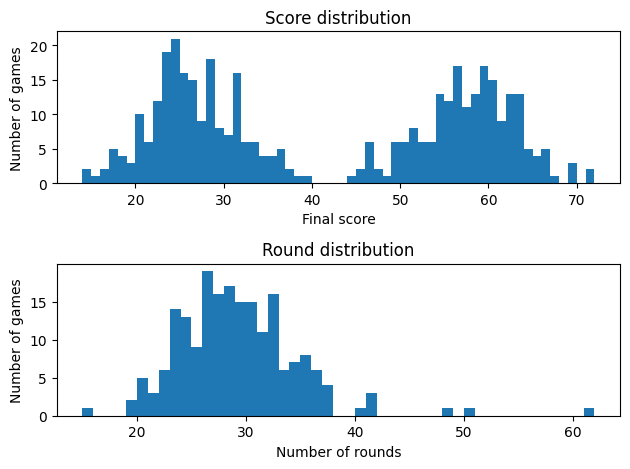

In [10]:
#remove outliers based on thresholds for score and length of game
score_threshold = 80
round_threshold = 50
print("Round and score distribution before outliers removed:")
plot_score_round_distributions(traces_cardcount)

traces_cardcount = traces_cardcount[(traces_cardcount['FinalScore'] <= score_threshold)
                                           & (traces_cardcount['TotalRounds'] <= round_threshold)]
new_game_id_list =  traces_cardcount['GameID'].unique()
traces_ngrams = traces_ngrams[traces_ngrams['GameID'].isin(new_game_id_list)]

Round and score distribution after outliers removed:


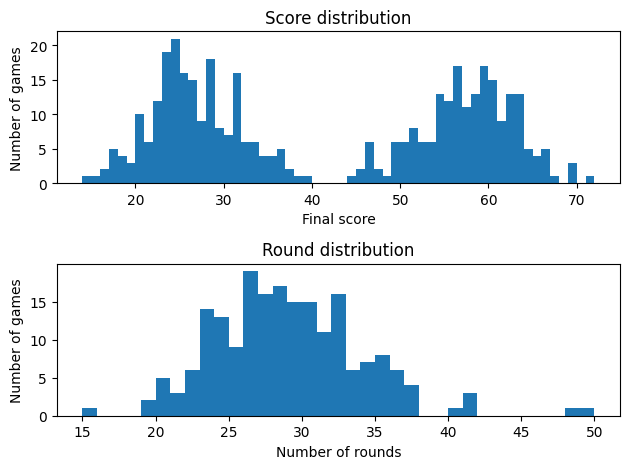

In [11]:
print("Round and score distribution after outliers removed:")
plot_score_round_distributions(traces_cardcount)

In [12]:
#flatten card count data so that we have a playtrace per row
traces_cardcount = flatten_card_count_data(traces_cardcount, card_types)
print(len(traces_cardcount))
print(len(traces_ngrams))

398
398


In [13]:
#Compute the all ngrams list by taking the total list of all observed n-grams for this tournament
all_ngrams_list = {}
for n in range(ngram_min, ngram_max + 1, ngram_stepsize):
  col_name = 'NGrams_' + str(n)
  all_ngrams_list[n] = []
  for row in traces_ngrams[col_name]:
    for gram in row:
      if gram not in all_ngrams_list[n]:
        all_ngrams_list[n].append(gram)
  print("Total number of Ngrams for N=" + str(n) + ":" + str(len(all_ngrams_list[n])))

Total number of Ngrams for N=1:70
Total number of Ngrams for N=2:669


In [14]:
#functions to support NGram analysis

#function to compute N-gram probabilities, returns either an array with probability values
#in the same order as ngrams in ngrams_all, or a dictionary with the n-grams as key
#Unobserved ngrams (i.e. ngrams in ngrams_all, that are not in the trace) are assigned
#a default probability of zero.
def calc_probabilities(ngrams_trace, ngrams_all, convertToArray = False):
    # Compute the frequency of ngrams in the trace
    frequency_counter = Counter(ngrams_trace)

    #calculate frequencies of all ngrams in ngrams_all that appear in the playtrace
    event_count = {gram: frequency_counter.get(gram, 0) for gram in ngrams_all}

    #normalise each entry with the number of n-grams observed for that trace, to convert
    #counts into probabilities
    trace_n_gram_count = sum(frequency_counter.values())
    probs = {key: value / (1.0*trace_n_gram_count) for key, value in event_count.items()}

    if convertToArray:
        probs = np.array(list(probs.values()))

    return probs

#function to take a probability dictionary and create an array
def prob_dict_to_array(prob_dict):
    return np.array(list(prob_dict.values()))

#funciton to take probability array and convert to dictionary with n-grams as keys
#assumes ordering has been maintained
def prob_array_to_dict(prob_array, ngrams_all):
    prob_dict = {}
    index = 0
    for gram in ngrams_all:
        prob_dict[gram] = prob_array[index]
        index+=1
    return prob_dict

#find the common set of ngrams between two probability dictionaries, with probabilities
#above a given threshold
def return_common_ngrams_above_threshold(prob_dict1, prob_dict2, threshold):
    common_ngrams = []
    #look for entries in the first dictionary with non-zero values
    for key, value in prob_dict1.items():
        if value > threshold:
            common_ngrams.append(key)
    #repeat for the second dictionary but avoiding duplicates
    for key, value in prob_dict2.items():
        if (value > threshold) and (key not in common_ngrams):
             common_ngrams.append(key)
    return common_ngrams

#convert a list of ngram tuples into a list of strings
def convert_ngram_tuples_to_strings(ngrams_list):
    ngrams_str = []
    for tuple_item in ngrams_list:
        tuple_str = ''
        for index, element in enumerate(tuple_item):
            if index != (len(tuple_item)-1):
                tuple_str += element + '|'
            else:
                tuple_str += element
        ngrams_str.append(tuple_str)
    return ngrams_str

#function to calculate Jensen-Shannon distance
def kl_divergence(p, q):
    eps = 0.00000001
    return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))

def jensen_shannon_distance(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (kl_divergence(p, m) + kl_divergence(q, m))

In [15]:
#add columns to trace data containing arrays for probability data
for n in range(ngram_min, ngram_max + 1, ngram_stepsize):
  col_name_1 = 'ProbDict_' + str(n)
  col_name_2 = 'ProbArray_' + str(n)
  col_name_3 = 'NGrams_' + str(n)
  traces_ngrams[col_name_1] = traces_ngrams.apply(lambda row: calc_probabilities(row[col_name_3], all_ngrams_list[n], False), axis = 1)
  traces_ngrams[col_name_2] = traces_ngrams.apply(lambda row: calc_probabilities(row[col_name_3], all_ngrams_list[n], True), axis = 1)

In [16]:
example_dict = traces_ngrams['ProbDict_2'].iloc[0]
example_array = traces_ngrams['ProbArray_2'].iloc[0]

#check translation functions work
example_dict_converted_to_array = prob_dict_to_array(example_dict)
example_array_converted_to_dict = prob_array_to_dict(example_array, all_ngrams_list[2])

print(np.array_equal(example_dict_converted_to_array, example_array))
print(example_array_converted_to_dict == example_dict)

#check probability array is normalised
print(sum(example_array))

True
True
0.9999999999999991


In [17]:
#calculate distance matrix for all pairwise trace combinations
def symm_distance_matrix(df, distance_func, colname):
    traces = df[colname].tolist()
    index_combinations = list(combinations(range(len(traces)), 2))

    distance_values = [distance_func(traces[i],traces[j]) for i, j in index_combinations]

    num_rows = len(df)
    distance_matrix = pd.DataFrame(index=range(num_rows), columns=range(num_rows))

    for (i, j), distance_value in zip(index_combinations, distance_values):
        distance_matrix.at[i, j] = distance_value
        distance_matrix.at[j, i] = distance_value  # mirror the value

    return distance_matrix.fillna(0)  # fill NaN values with zeros for diagonal elements

#calculate distance matrix for all pairwise trace combinations using Jensen-Shannon distance measure
js_dist_matrix = {}
for n in range(ngram_min, ngram_max + 1, ngram_stepsize):
  col_name = 'ProbArray_' + str(n)
  js_dist_matrix[n] = symm_distance_matrix(traces_ngrams, jensen_shannon_distance, col_name)

<ipython-input-14-c6271380372b>:68: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
<ipython-input-14-c6271380372b>:68: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
<ipython-input-14-c6271380372b>:68: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
<ipython-input-14-c6271380372b>:68: RuntimeWarning: invalid value encountered in divide
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
<ipython-input-14-c6271380372b>:68: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(p < eps, 0, np.where(q < eps,0, p * np.log(p / (1.0*q)))))
<ipython-input-14-c6271380372b>:68: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p < eps, 0, np.where(q < ep

In [18]:
#functions to perfom clustering analysis
def sa_kmedoids(dist_matrix, num_clusters):
  clusterer = KMedoids(n_clusters=num_clusters,
                       metric='precomputed',
                       method='alternate',
                       init='k-medoids++',
                       max_iter=300,
                       random_state= 0).fit(dist_matrix)
  return clusterer.inertia_, clusterer.labels_

def sa_kmeans(data, num_clusters):
  clusterer = KMeans(n_clusters=num_clusters,
                      init='k-means++',
                      n_init= 'warn',
                      max_iter=300,
                      tol=0.0001,
                      verbose=0,
                      random_state=0,
                      copy_x=True,
                      algorithm='lloyd').fit(data)
  return clusterer.inertia_, clusterer.labels_

def sa_dbscan(data, minPts, epsilon, use_dist_matrix = False, dist_matrix = None):
  if not use_dist_matrix:
    dbscan_clustering = DBSCAN(eps= epsilon, min_samples= minPts, metric = 'euclidean').fit(data)
  else:
    dbscan_clustering = DBSCAN(eps= epsilon, min_samples= minPts, metric = 'precomputed').fit(dist_matrix)
  return dbscan_clustering.labels_

def sa_spectral_clustering_KNN(data, num_clusters, num_nearest_neighbours):
  #here the affinity matrix is based on K-NN
  spec_clustering_knn = SpectralClustering(n_clusters= num_clusters,
                                            random_state=0,
                                            affinity = 'nearest_neighbors',
                                            n_neighbors = num_nearest_neighbours,
                                            assign_labels='kmeans').fit(data)
  return spec_clustering_knn.labels_

def sa_spectral_clustering_RBF(data, num_clusters, gamma_val):
  spec_clustering_rbf = SpectralClustering(n_clusters= num_clusters,
                                        random_state=0,
                                        gamma = gamma_val,
                                        affinity = 'rbf',
                                        assign_labels='kmeans').fit(data)
  return spec_clustering_rbf.labels_

def sa_spectral_clustering_DM(dist_matrix, num_clusters):
  spec_clustering_DM = SpectralClustering(n_clusters= num_clusters,
                                        random_state=0,
                                        affinity = 'precomputed',
                                        assign_labels='kmeans').fit(dist_matrix)
  return spec_clustering_DM.labels_

In [19]:
#functions to generate output files
def output_silhouette_plot(outputfilename, silhouette_samples, silhouette_avg, cluster_labels):
  n_clusters = len(np.unique(cluster_labels))

  #Create a subplot with 1 row and 1 columns
  fig, ax1 = plt.subplots(1,1, clear = True)
  fig.set_size_inches(7, 3.5)

  # The silhouette coefficient can range from -1, 1
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(silhouette_samples) + (n_clusters + 1) * 10])

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = silhouette_samples[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  #ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values for K=" + str(n_clusters))
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  #plt.suptitle(
  #    "Silhouette analysis for " + cluster_method_str + " clustering",
  #    fontsize=14,
  #    fontweight="bold",
  #)
  plt.ioff()
  plt.savefig(outputfilename +'.png', format = 'png')

#output list of silhouette averages with a key (e.g. no of clusters)
def output_silhouette_avgs(outputfilename, silhouette_avgs_dict):
  #output silhouette averages to file
  with open(outputfilename + '.csv', 'w', newline='') as csv_file:
    fieldnames = silhouette_avgs_dict.keys()
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    # Write the header
    writer.writeheader()
    # Write the data
    writer.writerow(silhouette_avgs_dict)

  return None

#output single best silhouette average and corresponding parameter values
def output_best_silhouette_average_and_params(outputfilename, best_sil_avg, param_list, paramlabel_list):
  with open(outputfilename + '.csv', 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Best Silhouette Average: ', best_sil_avg])
    for index in range(0, len(param_list)):
      writer.writerow([paramlabel_list[index], param_list[index]])

def output_inertia_plot(outputfilename, inertia_vals_dict, scalar):
  #scale the inertia vals, typically the scalar value will be the inertia for clustering on one cluster
  inertia_vals_array = np.array([value for value in inertia_vals_dict.values()])
  inertia_vals_scaled = inertia_vals_array/scalar
  cluster_list = np.array([cluster for cluster in inertia_vals_dict.keys()])
  inertia_vals_scaled = np.insert(inertia_vals_scaled, 0, 1.0)
  cluster_list = np.insert(cluster_list, 0, 1)

  #plot as a line plot
  fig, ax = plt.subplots(num=1,clear=True)
  ax.plot(cluster_list, inertia_vals_scaled)
  ax.set_xticks(cluster_list)
  ax.set_xlabel("Number of clusters")
  ax.set_ylabel("Scaled inertia")
  plt.ioff()
  plt.savefig(outputfilename +'.png', format = 'png')


In [ ]:
#next we perfom our main loop, looping over clustering methods and types of play trace and outputting results to file
clustering_methods = ['KMeans', 'KMedoids', 'DBSCAN', 'SPCluster_KNN','SPCluster_RBF', 'SPCluster_DM']

play_trace_type_list = ['CardCount']
#play_trace_type_list = []
for n in range(ngram_min, ngram_max + 1, ngram_stepsize):
  play_trace_type_list.append('NGram_' + str(n))

for playtrace_type in play_trace_type_list:
  #select data
  if playtrace_type == 'CardCount':
    cols = ['Player', 'GameID', 'AgentName', 'AgentNameOpponent', 'Win', 'FinalScore', 'TotalRounds']
    traces = traces_cardcount.drop(cols, axis = 1)
  else:
    n_gram_type = int(playtrace_type[-1:])
    traces = traces_ngrams

  #loop over clustering methods
  for cluster_method in clustering_methods:
    #perfom Kmeans and KMedoids clustering
    sil_avg = {}
    inertia = {}
    if (cluster_method == 'KMeans' and playtrace_type == 'CardCount') or (cluster_method == 'KMedoids' and playtrace_type != 'CardCount'):
      for n_clusters in range(clusters_min, clusters_max + 1, clusters_stepsize):
        if cluster_method == 'KMeans' and playtrace_type == 'CardCount':
          inertia[n_clusters], cluster_labels = sa_kmeans(traces, n_clusters)
          sil_avg[n_clusters] = silhouette_score(traces, cluster_labels)
          sil_coeffs = silhouette_samples(traces, cluster_labels)
        elif cluster_method == 'KMedoids' and playtrace_type != 'CardCount':
          inertia[n_clusters], cluster_labels = sa_kmedoids(js_dist_matrix[n_gram_type], n_clusters)
          sil_avg[n_clusters] = silhouette_score(js_dist_matrix[n_gram_type], cluster_labels, metric = 'precomputed')
          sil_coeffs = silhouette_samples(js_dist_matrix[n_gram_type], cluster_labels, metric = 'precomputed')

        #output silhouette plots
        outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_plot_' + cluster_method + '_' + playtrace_type + '_K_' + str(n_clusters) + '_' + tag_for_dir_and_filenames
        output_silhouette_plot(outputfilename, sil_coeffs, sil_avg[n_clusters], cluster_labels)

      #output silhouette averages to file
      outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_averages_' + cluster_method + '_' + playtrace_type + '_' + tag_for_dir_and_filenames
      output_silhouette_avgs(outputfilename, sil_avg)

      #output a scaled inertia value plot
      outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/'  + 'inertia_plot_' + cluster_method + '_' + playtrace_type + '_' + tag_for_dir_and_filenames
      if cluster_method == 'KMeans' and playtrace_type == 'CardCount':
        scalar, _ = sa_kmeans(traces, 1)
      elif cluster_method == 'KMedoids' and playtrace_type != 'CardCount':
        scalar, _ = sa_kmedoids(js_dist_matrix[n_gram_type], 1)
      output_inertia_plot(outputfilename, inertia, scalar)

    elif cluster_method == 'DBSCAN':
      #note for DBSCAN inertia is not a valid metric (dependent on spherical clusters), so we look for the
      #best silhouette average and just output this result.
      clusters_greater_than_one_found = False
      best_sil_avg = -10000
      best_sil_coeffs = None
      best_minpts = 0
      best_epsilon = 0
      best_cluster_labels = None
      best_noise_ratio = 0 #this is the noise ratio in the case with the highest silhouette average
      #note for DBSCAN our distances must be less than or equal to one. The JS distance has
      #an upper bound of one, so no issues for NGram case. For CardCount case we need to
      #normalise our playtrace vectors
      if playtrace_type == 'CardCount':
        #normalise trace vector
        traces_normalised = traces.apply(lambda row: row/np.linalg.norm(row), axis = 1)
      for minpts in range(minpts_min, minpts_max, minpts_stepsize):
        for epsilon in np.arange(epsilon_min, epsilon_max, epsilon_stepsize):
          if playtrace_type == 'CardCount':
            cluster_labels = sa_dbscan(traces_normalised, minpts, epsilon)
            #in DBSCAN anything with a label of '-1' is treated as noise
            #so we need to do the following:
            #1. Keep a record of the portion of traces that are classified as noise, too many and the results should be ignored
            #2. Filter our traces to remove traces that are considered as noise, prior to computing the silhouette average
            noise_ratio = np.sum(cluster_labels == -1)/len(traces_normalised)
            traces_filtered = traces_normalised[cluster_labels > -1]
            cluster_labels_filtered = cluster_labels[cluster_labels > -1]
            #silhouette scores only make sense for two or more clusters
            if (len(np.unique(cluster_labels_filtered))) > 1:
              clusters_greater_than_one_found = True
              sil_avg = silhouette_score(traces_filtered, cluster_labels_filtered)
              if sil_avg > best_sil_avg:
                best_sil_avg = sil_avg
                best_sil_coeffs = silhouette_samples(traces_filtered, cluster_labels_filtered)
                best_minpts = minpts
                best_epsilon = epsilon
                best_cluster_labels = cluster_labels_filtered
                best_noise_ratio = noise_ratio
          elif playtrace_type != 'CardCount':
            cluster_labels = sa_dbscan(traces, minpts, epsilon, True, js_dist_matrix[n_gram_type])
            noise_ratio = np.sum(cluster_labels == -1)/len(traces)
            indices_to_remove = [i for i, value in enumerate(cluster_labels) if value == -1]
            dist_matrix_filtered = js_dist_matrix[n_gram_type].drop(index=indices_to_remove, columns=indices_to_remove)
            cluster_labels_filtered = cluster_labels[cluster_labels > -1]
            if (len(np.unique(cluster_labels_filtered))) > 1:
              clusters_greater_than_one_found = True
              sil_avg = silhouette_score(dist_matrix_filtered, cluster_labels_filtered, metric = 'precomputed')
              if sil_avg > best_sil_avg:
                pdb.set_trace()
                best_sil_avg = sil_avg
                best_sil_coeffs = silhouette_samples(dist_matrix_filtered, cluster_labels_filtered, metric = 'precomputed')
                best_minpts = minpts
                best_epsilon = epsilon
                best_cluster_labels = cluster_labels_filtered
                best_noise_ratio = noise_ratio

      #output silhouette plots
      if (clusters_greater_than_one_found == True):
        #pdb.set_trace()
        outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_plot_' + cluster_method + '_' + playtrace_type + '_eps_' + str(round(best_epsilon,2)) + '_minpts_' + str(best_minpts) + '_' + tag_for_dir_and_filenames
        output_silhouette_plot(outputfilename, best_sil_coeffs, best_sil_avg, best_cluster_labels)
        #output best silhouette average result
        outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'best_silhouette_avg_' + cluster_method + '_' + playtrace_type + '_' + tag_for_dir_and_filenames
        params = [best_minpts, best_epsilon, best_noise_ratio]
        paramlabels_list = ['minpts', 'epsilon', 'noise ratio']
        output_best_silhouette_average_and_params(outputfilename, sil_avg, params, paramlabels_list)
      else:
        print("No clustering found for DBSCAN for " + playtrace_type)

    elif cluster_method == 'SPCluster_KNN':
      #this is only applicable for Euclidean distances. Note inertia is not applicable in this case
      best_sil_avg = 0
      best_sil_coeffs = 0
      best_cluster_labels = None
      best_n_clusters = 0
      best_knn = 0
      if playtrace_type == 'CardCount':
        for knn in range(nearest_neighbours_min, nearest_neighbours_max, nearest_neighbours_stepsize):
          for n_clusters in range(clusters_min, clusters_max + 1, clusters_stepsize):
            cluster_labels = sa_spectral_clustering_KNN(traces, n_clusters, knn)
            sil_avg = silhouette_score(traces, cluster_labels)
            if sil_avg > best_sil_avg:
              best_sil_avg = sil_avg
              best_sil_coeffs = silhouette_samples(traces, cluster_labels)
              best_n_clusters = n_clusters
              best_knn = knn
              best_cluster_labels = cluster_labels

        #output silhouette plot
        outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_plot_' + cluster_method + '_' + playtrace_type + '_K_' + str(best_n_clusters) + '_knn_' + str(best_knn) + '_' + tag_for_dir_and_filenames
        output_silhouette_plot(outputfilename, best_sil_coeffs, best_sil_avg, best_cluster_labels)

        #output silhouette averages to file
        outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'best_silhouette_avg_' + cluster_method + '_' + playtrace_type + '_' + tag_for_dir_and_filenames
        params = [best_n_clusters, best_knn]
        paramlabels_list = ['n_clusters', 'knn']
        output_best_silhouette_average_and_params(outputfilename, best_sil_avg, params, paramlabels_list)

    elif cluster_method == 'SPCluster_RBF':
      #this is only applicable for Euclidean distances, and we aprroach in same way as for KNN
      clusters_greater_than_one_found = False
      best_sil_avg = 0
      best_sil_coeffs = 0
      best_cluster_labels = None
      best_n_clusters = 0
      best_gamma = 0
      if playtrace_type == 'CardCount':
        for gamma in np.arange(gamma_min, gamma_max, gamma_stepsize):
          for n_clusters in range(clusters_min, clusters_max + 1, clusters_stepsize):
            cluster_labels = sa_spectral_clustering_RBF(traces, n_clusters, gamma)
            #for some reason RBF can return less clsuters than n_clusters. Dont undertand this....
            if (len(np.unique(cluster_labels_filtered))) > 1:
              clusters_greater_than_one_found = True
              sil_avg = silhouette_score(traces, cluster_labels)
              if sil_avg > best_sil_avg:
                best_sil_avg = sil_avg
                best_sil_coeffs = silhouette_samples(traces, cluster_labels)
                best_n_clusters = n_clusters
                best_gamma = gamma
                best_cluster_labels = cluster_labels

        #output silhouette plot
        if clusters_greater_than_one_found:
          outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_plot_' + cluster_method + '_' + playtrace_type + '_K_' + str(best_n_clusters) + '_gamma_' + str(best_gamma) + '_' + tag_for_dir_and_filenames
          output_silhouette_plot(outputfilename, best_sil_coeffs, best_sil_avg, best_cluster_labels)

          #output silhouette averages to file
          outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'best_silhouette_avg_' + cluster_method + '_' + playtrace_type + '_' + tag_for_dir_and_filenames
          params = [best_n_clusters, best_gamma]
          paramlabels_list = ['n_clusters', 'gamma']
          output_best_silhouette_average_and_params(outputfilename, best_sil_avg, params, paramlabels_list)
    elif cluster_method == 'SPCluster_DM':
      #this method using a pre-computed distance matrix and can be used with NGrams. In this case we just output the SA for each cluster value
      #and also giev the corresponding silhouette plot
      if playtrace_type != 'CardCount':
        sil_avgs = {}
        for n_clusters in range(clusters_min, clusters_max + 1, clusters_stepsize):
          cluster_labels = sa_spectral_clustering_DM(js_dist_matrix[n_gram_type], n_clusters)
          sil_avgs[n_clusters] = silhouette_score(js_dist_matrix[n_gram_type], cluster_labels, metric = 'precomputed')
          sil_coeffs = silhouette_samples(js_dist_matrix[n_gram_type], cluster_labels, metric = 'precomputed')

          #output silhouette plot
          outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_plot_' + cluster_method + '_' + playtrace_type + '_K_' + str(n_clusters) + '_' + tag_for_dir_and_filenames
          output_silhouette_plot(outputfilename, sil_coeffs, sil_avgs[n_clusters], cluster_labels)

        #output silhouette averages to file
        outputfilename = google_drive_parent_dir + 'Results_' + cluster_method + '/' + tag_for_dir_and_filenames + '/' + 'silhouette_avgs_' + cluster_method + '_' + playtrace_type + '_' + tag_for_dir_and_filenames
        output_silhouette_avgs(outputfilename, sil_avgs)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

No clustering found for DBSCAN for NGram_1
